## This is code for adding

### Imports and preloading

In [1]:
# import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import torch.optim as optim
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
path="../../input/final_split_training_augmented/train"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # You can test the normalization but if u apply remember to apply for testing
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

allDataSet = datasets.ImageFolder(root=path, transform=transform)
totalSize = len(allDataSet)
reductionRatio = 1
reducedSize = int(totalSize * reductionRatio)
indices = list(range(totalSize))
random.shuffle(indices)
reduced_indices = indices[:reducedSize]
reducedDataset = Subset(allDataSet, reduced_indices)

print(f"Reduced Train: {len(reducedDataset)}")
dataloader = DataLoader(reducedDataset, batch_size=32, shuffle=True, drop_last=True)


Reduced Train: 8025


In [3]:
path="../../input/final_split_training_augmented/eval"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

evalSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Reduced Train: {len(evalSet)}")
valLoader = DataLoader(evalSet, batch_size=32, shuffle=True)


Reduced Train: 579


In [4]:
# Number of classes in your dataset
num_classes = len(reducedDataset.dataset.classes) 
print(num_classes)

4


### Code Strucutre

In [5]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
     
class DenseResidualBlock(nn.Module):
    """
    Dense Residual Block
    Processes input with skip connections and returns in the same number of channels

    inChannels (int): the number of input channels going into the block (and also being returned)
    internalSize (int): the number of channels within the internal layers of the block
    """
    def __init__(self, in_features, hidden_size=128, dropout_rate=0.3):
        super(DenseResidualBlock, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, in_features)
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        identity = x  # Save for residual

        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.fc2(out)))

        return identity + out 
  
class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:
                param.requires_grad = True
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            DenseResidualBlock(in_features=256),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
        

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

optimizer = optim.Adam(model.base.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

### Training

In [6]:
epochs = 10
best_val_acc = 0.0
patience = 3
trigger_times = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    epochLoss = running_loss / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/total:.4f} Accuracy: {acc:.4f}")
    train_losses.append(epochLoss)

    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for images, labels in valLoader:  # assumes valLoader is defined
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

    valLoss = eval_loss / eval_total
    val_acc = eval_correct / eval_total
    val_losses.append(valLoss)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "../../models/unclean/newClassifierStructure.pth")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/10] Loss: 1.2528 Accuracy: 0.4615
Eval  Loss: 1.1923 | Accuracy: 0.4611
Epoch [2/10] Loss: 0.7365 Accuracy: 0.7111
Eval  Loss: 1.7424 | Accuracy: 0.4577
No improvement. Trigger 1/3
Epoch [3/10] Loss: 0.3719 Accuracy: 0.8601
Eval  Loss: 2.2107 | Accuracy: 0.4594
No improvement. Trigger 2/3
Epoch [4/10] Loss: 0.2013 Accuracy: 0.9319
Eval  Loss: 2.3796 | Accuracy: 0.4819
Epoch [5/10] Loss: 0.1356 Accuracy: 0.9541
Eval  Loss: 2.9530 | Accuracy: 0.4542
No improvement. Trigger 1/3
Epoch [6/10] Loss: 0.0977 Accuracy: 0.9683
Eval  Loss: 2.8871 | Accuracy: 0.4611
No improvement. Trigger 2/3
Epoch [7/10] Loss: 0.0758 Accuracy: 0.9754
Eval  Loss: 4.0801 | Accuracy: 0.4629
No improvement. Trigger 3/3
Early stopping triggered.


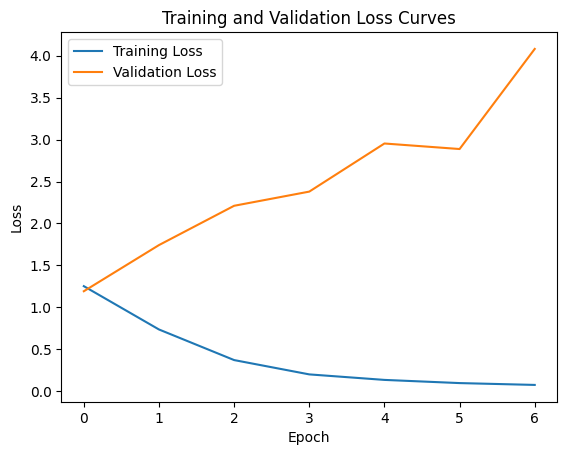

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


### Testing

In [8]:
path="../../input/final_split_training_augmented/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)


Test set: 572


In [9]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [11]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
     
class DenseResidualBlock(nn.Module):
    """
    Dense Residual Block
    Processes input with skip connections and returns in the same number of channels

    inChannels (int): the number of input channels going into the block (and also being returned)
    internalSize (int): the number of channels within the internal layers of the block
    """
    def __init__(self, in_features, hidden_size=128, dropout_rate=0.3):
        super(DenseResidualBlock, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, in_features)
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        identity = x  # Save for residual

        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.fc2(out)))

        return identity + out 
  
class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:
                param.requires_grad = True
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            DenseResidualBlock(in_features=256),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
        

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
model.load_state_dict(torch.load("../../models/unclean/newClassifierStructure.pth"))
model.eval()


CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [12]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.6853
Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.69      0.71       140
       happy       0.66      0.69      0.67       148
     relaxed       0.68      0.50      0.57       146
         sad       0.67      0.88      0.76       138

    accuracy                           0.69       572
   macro avg       0.69      0.69      0.68       572
weighted avg       0.69      0.69      0.68       572

Confusion Matrix:
[[ 96  19  12  13]
 [ 17 102  15  14]
 [ 11  30  73  32]
 [  5   4   8 121]]
